# SimRa - Analyse Teil 2 
## Outlier entfernen und Merkmale extrahieren

In diesem Notebook werden die **Merkmale Latitude (lat), Longitude (lon) und Timestamp (ts)** aus dem SimRa-Datensatz gefiltert, da wir für unser Projekt nur die Koordinaten der markierten Beinahe-Unfälle nutzen möchten. Zusätzlich haben wir uns für die Variable Timestamp entschieden, um ggf. noch Zusammenhänge mit zeitlichen Aspekten herausstellen zu können. 

Die **Outlier** werden idenifiziert, analysiert und ggf. entfernt. 

### 1. Laden der Daten
- Auswahl der Variablen: `lat`, `lon`, `ts`
- Ausgang bearbeitete Datei (siehe Notebook 01_simra_data_analyis): `simra_no_duplicates.csv`

In [1]:
import pandas as pd
import os

# Pfad zur CSV-Datei
file_path = os.path.join("..", "..", "data", "processed_data", "simra_no_duplicates.csv")
# file_path = 'https://github.com/simra-project/simra-project.github.io/blob/master/incidents/Berlin-incidents.csv'

# Spalten definieren
columns = ['lat', 'lon', 'ts']

df = pd.read_csv(file_path, usecols=columns)

# Timestamp-Spalte "ts" in ein lesbares Datumsformat umwandeln
# df['ts'] = pd.to_datetime(df['ts'], unit='ms')

df.head(3)

,lat,lon,ts
0,52.532325,13.394867,1572971392862
1,52.560305,13.354131,1575045211806
2,52.561502,13.354355,1575045239094


**Anmerkung zu Latitude und Longitude**: 
- meistens werden 6 Nachkommastellen verwendet, was einer Genauigkeit von 1 Meter entspricht
- hier wird der Output auf 6 Nachkommastellen gerundet

In [2]:
# Anpassen der Anzeigeoptionen im Jupyter Notebook
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_colwidth', None)

### 2. Übersicht & grundlegende Statistiken

In [3]:
df.shape

(17817, 3)

In [4]:
df.describe()

,lat,lon,ts
count,17817.000000,17817.000000,1.781700e+04
mean,52.512268,13.379104,1.616309e+12
std,0.050130,0.079941,3.698207e+10
min,48.147412,8.297819,1.042728e+12
25%,52.496547,13.353708,1.583739e+12
50%,52.518982,13.380811,1.619801e+12
75%,52.536681,13.405090,1.648227e+12
max,52.766957,13.885871,1.680767e+12


### 2.2. Fehlende Werte und Datenqualität

In [5]:
# Anzahl eindeutiger Werte pro Spalte
for col in df.columns:
    print(col)
    print(df[col].nunique())

lat
17762
lon
17774
ts
17803


In [6]:
# Überprüfung auf fehlende Werte
df.isnull().sum()

lat    0
lon    0
ts     0
dtype: int64

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17817 entries, 0 to 17816
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   lat     17817 non-null  float64
 1   lon     17817 non-null  float64
 2   ts      17817 non-null  int64  
dtypes: float64(2), int64(1)
memory usage: 417.7 KB


In [8]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%pylab inline

font = {'family' : 'serif',
        'size'   : 28}

matplotlib.rc('font', **font)

import seaborn as sns
sns.set(style="darkgrid", color_codes=True)
sns.set_context("paper", font_scale=1.5)

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [9]:
print(df.columns)

Index(['lat', 'lon', 'ts'], dtype='object')


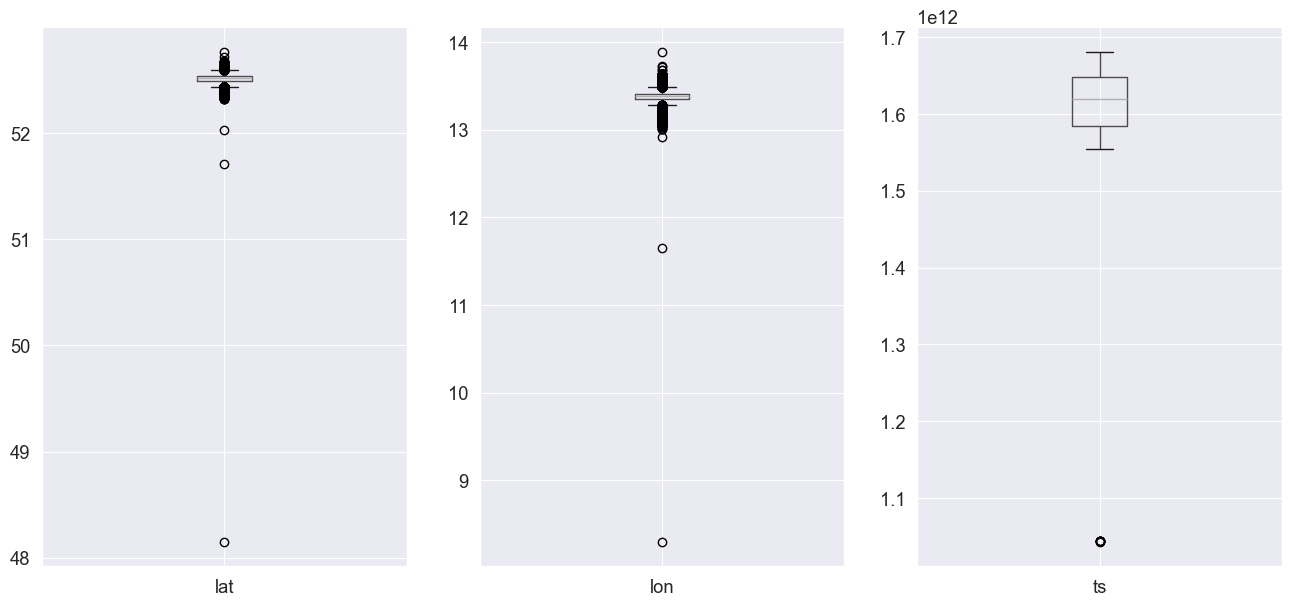

In [10]:
# Boxplot verschiedener metrischer Variablen(lat, lon, ts), um z.B. Outlier zu erkennen
fig, ax = plt.subplots(1, 3, figsize=(16,7))
for i, col in enumerate(['lat', 'lon', 'ts']):
    df.boxplot(column=col, ax=ax[i]);

- ToDo: genauere Untersuchung der Outlier (siehe weiter unten)

## ProfileReport

In [11]:
from ydata_profiling import ProfileReport
profile = ProfileReport(df, title="Profiling Report")

The HTML report can be directly embedded in a cell in a similar fashion:

In [12]:
profile.to_notebook_iframe()


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### Visualisierung -  Zeitliche Verteilung zu den Beinaheunfällen

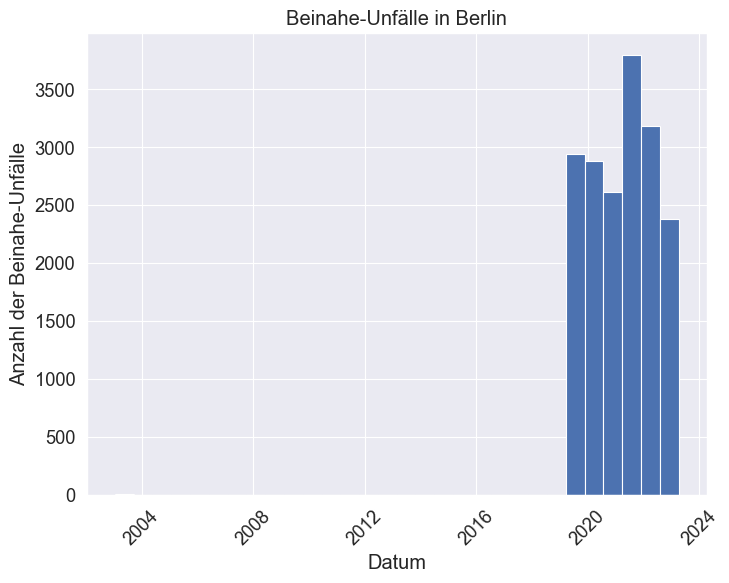

In [15]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Spalte "ts" in ein Pandas-Timestamp-Objekt umwandeln
df['ts'] = pd.to_datetime(df['ts'], unit='ms')

# Histogramm der 'ts'-Spalte 
plt.figure(figsize=(8, 6))
plt.hist(df['ts'], bins=30)  
plt.title('Beinahe-Unfälle in Berlin')
plt.xlabel('Datum')
plt.ylabel('Anzahl der Beinahe-Unfälle')
plt.xticks(rotation=45)

plt.grid(True)
plt.show()


## 3. Auffälligkeiten

### 3.1. Auffälligkeiten Koordinaten

- keine fehlenden Werte
- Es gibt `duplicate rows` --> `Dataset has 169 (0.9%) duplicate rows`
- Dopplungen in den Beschreibungen --> bei genauerer Kontrolle: minimale Abweichung der Angaben zu ts, lon, lat --> ToDo: *Wie gehen wir damit um?*
- `lat` is highly skewed (γ1 = -37.40688387) --> *ToDo: genauer anschauen*

**Latitude lat**
- eindeutige Daten (Distinct): 98.5%
- mehrere Werte außerhalb des des Längengrades innerhalb Berlin/Potsdam --> --> siehe `Minimum 10 Values` & `Maximum` 
  
**Longitude lon**
- eindeutige Daten (Distinct): 98.5%
- min. 3 Werte die deutlich außerhalb des Gebietes (Berlin/Potsdam) liegen --> siehe `Minimum 10 Values`

### Visualisierung der Verteilung der Variable `lat`
- `lat is highly skewed (γ1 = -37.40688387)`

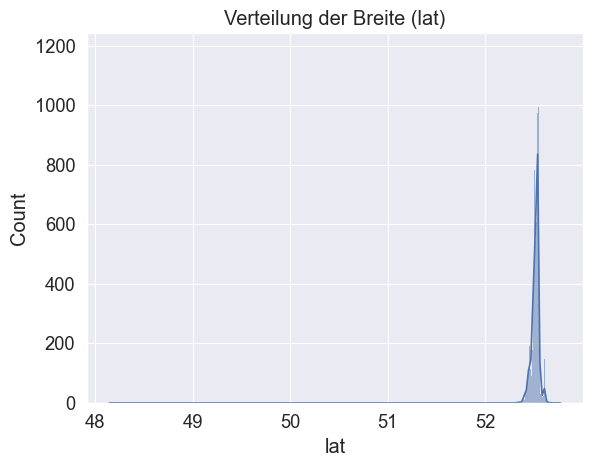

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(df['lat'], kde=True)
plt.title('Verteilung der Breite (lat)')
plt.show()

- Einzelne Werte liegen deutlich außerhalb der region Berlin. 

### 3.2. Auffäligkeiten Timestamp / Datum

- Minimum (umgerechnet): 16.Jan.2003, 14:41:40  --> *insgesamt 7 Werte von 2003!* (siehe `Minimum 10 Values`); danach Beginn mit 1.April 2019 &rarr; Die Aufzeichnungen des SimRa-Datensatzes starten erst 2019!
- Maximum: 6.Apr.2023, 07:46:40 &rarr; letzte Aufzeichnungen in dem Datensatz April 2023
- eindeutige Daten (Distinct): 98.7%

[Bsp. Umrechnung Timesatmp: 1.0427281e+12
= 1.0427281 × 10^12
= 1042728100000 ]

In [17]:
# Minimales und maximales Datum im Datensatz
min_timestamp = df['ts'].min()
max_timestamp = df['ts'].max()

print("Earliest Timestamp:", min_timestamp)
print("Latest Timestamp:", max_timestamp)

Earliest Timestamp: 2003-01-16 14:42:12.999000
Latest Timestamp: 2023-04-06 07:46:51


## 4. Daten bereinigen 
### Längengrade, Breitengrade (nur Berlin) und Datum filtern (ab 2019 und bis 2024)
- Outlier sollen entfernt entfernen
- Daten zu Potsdam sollen aus dem DataFrame entfernt werden &rarr; wir betrachten in unserem Projekt nur die Region Berlin
- **geografische Grenzen**: Dazu nutzen wir eine vereinfachte Methode &rarr; Wir ziehen ein Rechteck um Berlin mit dem südlichsten und nördlichsten Breitengrad sowie dem westlichsten und östlichsten Längengrad von Berlin. Alle Koordinaten, die außerhalb dieses Bereichs liegen werden entfernt.

In [18]:
# geografische Grenzen für Berlin --> vereinfachtes Rechteck um Berlin
min_lon_berlin = 13.0883
max_lon_berlin = 13.7612
min_lat_berlin = 52.3570
max_lat_berlin = 52.6755

- **Grenzen für die Zeitwerte**: ab 2019 (Beginn der Aufzeichnungen der SimRa-Daten) bis Ende 2023 (bis dahin gibt es aufgezeichnete Daten in dem Datensatz)

In [19]:
# Grenzen für Zeitfilter
start_date = pd.Timestamp('2019-01-01')  # ab 2019
end_date = pd.Timestamp('2024-01-01') # bis End 2023

In [20]:
# Spalte "ts" in ein Pandas-Timestamp-Objekt umwandeln
df['ts'] = pd.to_datetime(df['ts'], unit='ms')

In [21]:
# Test, ob das jahr 2003 noch enthalten ist
year = 2003

if (df['ts'].dt.year == year).any():
    print(f"Das Jahr {year} ist im DataFrame enthalten.")
else:
    print(f"Das Jahr {year} ist nicht im DataFrame enthalten.")


Das Jahr 2003 ist im DataFrame enthalten.


### Filtern der Daten nach Zeit und Koordinaten

In [29]:
df_no_outlier = df[(df['ts'] >= start_date) & (df['ts'] < end_date) &
                 (df['lon'] >= min_lon_berlin) & (df['lon'] <= max_lon_berlin) &
                 (df['lat'] >= min_lat_berlin) & (df['lat'] <= max_lat_berlin)]

df_no_outlier.head(3)

,lat,lon,ts
0,52.532325,13.394867,2019-11-05 16:29:52.862
1,52.560305,13.354131,2019-11-29 16:33:31.806
2,52.561502,13.354355,2019-11-29 16:33:59.094


In [30]:
# Speichern der bereinigten Daten mit ausgewählten Merkmalen
final_data_path = os.path.join("..", "..", "data", "processed_data", "simra_final_data.csv")
df_no_outlier.to_csv(final_data_path, index=False)

**--> Alternative für Koordianten filtern: mit GeoPandas** &rarr; für genauere Auswahl 

#### Überprüfen des Zeitabschnitts: 

In [31]:
# Minimales und maximales Datum im Datensatz
min_timestamp = df_no_outlier['ts'].min()
max_timestamp = df_no_outlier['ts'].max()

print("Earliest Timestamp:", min_timestamp)
print("Latest Timestamp:", max_timestamp)

Earliest Timestamp: 2019-04-01 15:47:45.819000
Latest Timestamp: 2023-04-04 16:12:19


In [24]:
# 'ts' Spalte in datetime konvertieren
# df['ts'] = pd.to_datetime(df['ts'])

### Visualisierung der Beinhae-Unfälle in Berlin

PLOT DER KOORDINATEN - Beinahe-Unfälle in Berlin


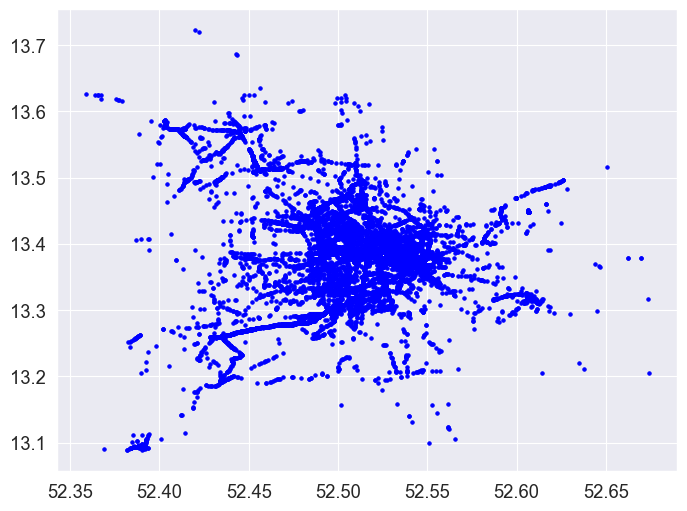

In [32]:
print ('PLOT DER KOORDINATEN - Beinahe-Unfälle in Berlin')

import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.scatter(df_no_outlier['lat'], df['lon'], c='blue', marker='.')

# TODO: Ausreißer entfernen

## Anmerkungen & Überlegungen zum weiterem Vorgehen: 
- Um Aussagegräftige Daten zu haben, benötigen wir zu den Beinaheunfälle auch die jeweils gemachten Fahrten pro Straßensegment. D.h. die Beinaheunfälle sollen zu der Gesamtzahl der gemachten Fahrten ins Verhältnis gesetzt werden.
- Um dies Berücksichtigen müssten wir im mächsten Schritt alle gemachten Fahrten aus den SimRa-Daten extrahieren. Anschließend könnten wir Polygone (Straßenabschnitte) bilden, für die dann jeweils das entsprechende Verhältnis von Beinaheunfällen zu gemachten Fahretn berechnet wird.
- Um diesen sehr Schritt zu überspringen, nutzen wir im weiteren Vorgehen einen **anderen SimRa-Datensatz**. Dieser enthält pro Polygon/Straßensegment alle entsprechenden Beinaheunfälle und alle gemachten Fahrten pro Segment. &rarr; siehe **SimRa Datensatz 02**: [simra_data_all.ipynb](notebooks/simra/simra_data_all.ipynb)